In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorboard.plugins import projector
from sklearn.model_selection import train_test_split

import csv
import os

C:\Users\2000w\anaconda3\envs\tf_2_5\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [325]:
f = open("DIAMOND_I_battle_data.csv")
rdr = csv.reader(f)
r = list(rdr)
f.close()

In [326]:
sentence = []
sentence_star = []
sentence_item = []
label = []

for _r in r[1:]:
    _sentence = ""
    _sentence_star = ""
    _sentence_item = ""
    flag = 0
    gamenum = _r[0]
    augments = []
    for ag in _r[1:4]:
        if "Augment" in ag:
            augments.append(ag)
    placement = _r[len(augments) + 1]
    champ_items = []
    for ci in _r[len(augments) + 2:]:
        if len(ci) > 0:
            champ_items.append(ci)
    champ_items = sorted(champ_items)
    
    for i in range(len(champ_items)):
        champ_items[i] = champ_items[i].replace('"', "").replace('[', "").replace("]", "").replace("'", "").replace(" ", "").split(",")
        if "TFT6" in champ_items[i][0]:
            flag = -1
        _sentence += champ_items[i][0] + " "
        _sentence_star += champ_items[i][0] + "-" + champ_items[i][1] + " "
        if "TFT_Item_ThiefsGloves" not in champ_items[i][2:5] and "TFT_Item_MadredsBloodrazor" not in champ_items[i][2:5]:
            _sentence_item += champ_items[i][0] + "-" + champ_items[i][2] + "-" + champ_items[i][3] + "-" + champ_items[i][4] + " "
        _label = placement
    if flag == 0:
        sentence_item.append(_sentence_item)
        sentence_star.append(_sentence_star)
        sentence.append(_sentence)
        label.append(_label)
        

data = pd.DataFrame(zip(sentence, sentence_star, sentence_item, label), columns = ['sentence', 'sentence_star', 'sentence_item', 'label'])


In [238]:
for i in range(255):
    print(data.iloc[i]['sentence'], data.iloc[i]['label'])
    print(data.iloc[i]['sentence_item'])

TFT7_Bard TFT7_Braum TFT7_Diana TFT7_Lillia TFT7_Nunu TFT7_Olaf TFT7_Shen TFT7_Yasuo  3
TFT7_Bard-TFT_Item_SpearOfShojin-noItems-noItems TFT7_Braum-noItems-noItems-noItems TFT7_Diana-TFT4_Item_OrnnZhonyasParadox-TFT_Item_FrozenHeart-TFT_Item_IonicSpark TFT7_Lillia-noItems-noItems-noItems TFT7_Nunu-noItems-noItems-noItems TFT7_Olaf-TFT_Item_InfinityEdge-TFT7_Item_AssassinEmblemItem-TFT_Item_RunaansHurricane TFT7_Shen-TFT_Item_ZekesHerald-noItems-noItems TFT7_Yasuo-TFT_Item_JeweledGauntlet-TFT_Item_SeraphsEmbrace-TFT_Item_Quicksilver 
TFT7_AurelionSol TFT7_Bard TFT7_Lulu TFT7_Nami TFT7_Ornn TFT7_Sylas TFT7_Zoe  3
TFT7_AurelionSol-TFT_Item_UnstableConcoction-TFT_Item_ArchangelsStaff-TFT_Item_SpearOfShojin TFT7_Bard-TFT_Item_SparringGloves-noItems-noItems TFT7_Lulu-noItems-noItems-noItems TFT7_Nami-TFT_Item_StatikkShiv-TFT_Item_Zephyr-noItems TFT7_Ornn-TFT_Item_ThiefsGloves-TFT_Item_RunaansHurricane-TFT_Item_MadredsBloodrazor TFT7_Sylas-TFT_Item_ThiefsGloves-TFT_Item_GuinsoosRageblade-TFT_

In [327]:
tokenizer = Tokenizer(filters = '', lower = False)
tokenizer.fit_on_texts(data['sentence'])
word_dic = tokenizer.word_index
word_count = tokenizer.word_counts
vocab_size = len(word_dic) + 1

tokenizer_star = Tokenizer(filters = '', lower = False)
tokenizer_star.fit_on_texts(data['sentence_star'])
word_dic_star = tokenizer_star.word_index
word_count_star = tokenizer_star.word_counts
vocab_size_star = len(word_dic_star) + 1

tokenizer_item = Tokenizer(filters = '-', lower = False)
tokenizer_item.fit_on_texts(data['sentence_item'])
word_dic_item = tokenizer_item.word_index
word_count_item = tokenizer_item.word_counts
vocab_size_item = len(word_dic_item) + 1

In [328]:
print(word_dic_item)

{'noItems': 1, 'TFT_Item_GuinsoosRageblade': 2, 'TFT_Item_RedBuff': 3, 'TFT_Item_Bloodthirster': 4, 'TFT_Item_GargoyleStoneplate': 5, 'TFT_Item_WarmogsArmor': 6, 'TFT_Item_SpearOfShojin': 7, 'TFT_Item_TitansResolve': 8, 'TFT7_Lulu': 9, 'TFT_Item_ArchangelsStaff': 10, 'TFT7_Sylas': 11, 'TFT_Item_InfinityEdge': 12, 'TFT_Item_Quicksilver': 13, 'TFT7_Ornn': 14, 'TFT7_Bard': 15, 'TFT_Item_UnstableConcoction': 16, 'TFT_Item_BrambleVest': 17, 'TFT7_Yasuo': 18, 'TFT_Item_Redemption': 19, 'TFT7_TrainerDragon': 20, 'TFT7_Item_TrainerSnax': 21, 'TFT_Item_DragonsClaw': 22, 'TFT_Item_JeweledGauntlet': 23, 'TFT7_Nami': 24, 'TFT_Item_HextechGunblade': 25, 'TFT_Item_IonicSpark': 26, 'TFT7_Hecarim': 27, 'TFT_Item_StatikkShiv': 28, 'TFT_Item_FrozenHeart': 29, 'TFT7_Shen': 30, 'TFT_Item_ZekesHerald': 31, 'TFT7_Zoe': 32, 'TFT7_Neeko': 33, 'TFT7_Illaoi': 34, 'TFT7_Heimerdinger': 35, 'TFT_Item_Morellonomicon': 36, 'TFT7_Swain': 37, 'TFT7_Sona': 38, 'TFT7_Tristana': 39, 'TFT_Item_SeraphsEmbrace': 40, 'TFT_It

In [329]:
def word_encoder(word_dic, word_data):
    vocab_size = len(word_dic) + 1
    encoded_data = np.zeros(vocab_size)
    for w in word_data:
        encoded_data[word_dic[w]] = 1
    return encoded_data
    
def word_decoder(word_dic, encoded_data):
    vocab_size = len(word_dic) + 1
    word_data = []
    for i, e in enumerate(encoded_data):
        if e == 1:
            word_data.append(list(word_dic)[i - 1])
    return word_data

def randomizer(_champ_list, N):
    champ_list = list(_champ_list)
    all_list = [w for w in word_dic]
    for c in champ_list:
        for i, al in enumerate(all_list):
            if al == c:
                del all_list[i]
    for _ in range(N):
        c = random.randint(0, len(champ_list) - 1)
        champ_list.pop(c)
    for _ in range(N):
        c = random.randint(0, len(all_list) - 1)
        champ_list.append(all_list.pop(c))
    
    trainer = 0
    if "TFT7_Heimerdinger" in champ_list:
        trainer += 1
    if "TFT7_Tristana" in champ_list:
        trainer += 1
    if "TFT7_Lulu" in champ_list:
        trainer += 1
    if trainer >= 2:
        if "TFT7_TrainerDragon" not in champ_list:
            champ_list.append("TFT7_TrainerDragon")
    else:
        if "TFT7_TrainerDragon" in champ_list:
            champ_list.pop(champ_list.index("TFT7_TrainerDragon"))
    champ_list = sorted(champ_list)
    return champ_list

In [330]:
data_M = np.zeros((len(data['sentence']) * 5, vocab_size))
data_N = np.zeros((len(data['sentence']) * 5, 5))

t = 0
for i, champ_list in enumerate(data['sentence']):
    champ_list = champ_list.split(" ")[:-1]
    if len(champ_list) > 5:
        for j in range(5):
            data_M[t] = word_encoder(word_dic, randomizer(champ_list, j))
            data_N[t][j] = 1
            t += 1
            
data_S = np.zeros((len(data['sentence_star']), vocab_size_star))
data_L = np.zeros((len(data['sentence_star']), 1))

for i, champ_list in enumerate(data['sentence_star']):
    champ_list = champ_list.split(" ")[:-1]
    data_S[i] = word_encoder(word_dic_star, champ_list)
    data_L[i] = [float(data['label'][i])]
    
data_I = np.zeros((len(data['sentence_item']) * 10, vocab_size_item))
data_R = np.zeros((len(data['sentence_item']) * 10, 1))

t = 0
for i, champ_list in enumerate(data['sentence_item']):
    champ_list = champ_list.split(" ")[:-1]
    for c in champ_list:
        champ_item = c.split("-")
        data_I[t] = word_encoder(word_dic_item, champ_item)
        data_R[t] = [float(data['label'][i])]
        t += 1
        
data_I = data_I[:t]
data_R = data_R[:t]

In [332]:
x_synergy_train, x_synergy_test, y_synergy_train, y_synergy_test = train_test_split(data_M, data_N, test_size=0.2, random_state=0)
x_rank_train, x_rank_test, y_rank_train, y_rank_test = train_test_split(data_S, data_L, test_size=0.2, random_state=0)
x_item_train, x_item_test, y_item_train, y_item_test = train_test_split(data_I, data_R, test_size=0.2, random_state=0)

In [131]:
# 시너지 모델
if not os.path.exists('/model'):
    os.makedirs('/model')

# 모델 구축
model = Sequential()
model.add(Dense(20, input_dim = len(x_synergy_train[0]), activation = 'relu'))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics = ['accuracy'])
history = model.fit(x_synergy_train, y_synergy_train, epochs=10, batch_size=100, validation_split=0.2)
model.save('model/my_model3.h5')

Epoch 1/10
1284/1284 [==============================] - 2s 1ms/step - loss: 1.5729 - accuracy: 0.2209 - val_loss: 1.5537 - val_accuracy: 0.2539
Epoch 2/10
1284/1284 [==============================] - 1s 1ms/step - loss: 1.5331 - accuracy: 0.2782 - val_loss: 1.5073 - val_accuracy: 0.3007
Epoch 3/10
1284/1284 [==============================] - 1s 1ms/step - loss: 1.4761 - accuracy: 0.3143 - val_loss: 1.4395 - val_accuracy: 0.3306
Epoch 4/10
1284/1284 [==============================] - 1s 1ms/step - loss: 1.4059 - accuracy: 0.3477 - val_loss: 1.3687 - val_accuracy: 0.3655
Epoch 5/10
1284/1284 [==============================] - 1s 1ms/step - loss: 1.3406 - accuracy: 0.3763 - val_loss: 1.3095 - val_accuracy: 0.3902
Epoch 6/10
1284/1284 [==============================] - 1s 1ms/step - loss: 1.2903 - accuracy: 0.3977 - val_loss: 1.2670 - val_accuracy: 0.4108
Epoch 7/10
1284/1284 [==============================] - 1s 1ms/step - loss: 1.2548 - accuracy: 0.4134 - val_loss: 1.2375 - val_accuracy:

In [202]:
# 순위 모델
if not os.path.exists('/model'):
    os.makedirs('/model')

# 모델 구축
model_rank = Sequential()
model_rank.add(Dense(20, input_dim = len(x_rank_train[0]), activation = 'relu'))
model_rank.add(Dense(20, activation = 'relu'))
model_rank.add(Dense(1))
model_rank.compile(loss = 'mse', optimizer = RMSprop(learning_rate = 0.001))
history = model_rank.fit(x_rank_train, y_rank_train, epochs=10, batch_size=10, validation_split=0.2)
model_rank.save('model/my_model_rank3.h5')

Epoch 1/10
2567/2567 [==============================] - 4s 1ms/step - loss: 3.6148 - val_loss: 2.5770
Epoch 2/10
2567/2567 [==============================] - 3s 1ms/step - loss: 2.4319 - val_loss: 2.3687
Epoch 3/10
2567/2567 [==============================] - 3s 1ms/step - loss: 2.2318 - val_loss: 2.2792
Epoch 4/10
2567/2567 [==============================] - 4s 1ms/step - loss: 2.1230 - val_loss: 2.2321
Epoch 5/10
2567/2567 [==============================] - 3s 1ms/step - loss: 2.0556 - val_loss: 2.1810
Epoch 6/10
2567/2567 [==============================] - 3s 1ms/step - loss: 2.0137 - val_loss: 2.1822
Epoch 7/10
2567/2567 [==============================] - 3s 1ms/step - loss: 1.9767 - val_loss: 2.1193
Epoch 8/10
2567/2567 [==============================] - 3s 1ms/step - loss: 1.9495 - val_loss: 2.1398
Epoch 9/10
2567/2567 [==============================] - 3s 1ms/step - loss: 1.9217 - val_loss: 2.1146
Epoch 10/10
2567/2567 [==============================] - 3s 1ms/step - loss: 1.900

In [333]:
# 아이템 모델
if not os.path.exists('/model'):
    os.makedirs('/model')

# 모델 구축
model_item = Sequential()
model_item.add(Dense(20, input_dim = len(x_item_train[0]), activation = 'relu'))
model_item.add(Dense(20, activation = 'relu'))
model_item.add(Dense(1))
model_item.compile(loss = 'mse', optimizer = RMSprop(learning_rate = 0.01))
history = model_item.fit(x_item_train, y_item_train, epochs=10, batch_size=100, validation_split=0.2)
model_item.save('model/my_model_item3.h5')

Epoch 1/10
1788/1788 [==============================] - 3s 1ms/step - loss: 5.0455 - val_loss: 5.0254
Epoch 2/10
1788/1788 [==============================] - 2s 1ms/step - loss: 4.9215 - val_loss: 4.9799
Epoch 3/10
1788/1788 [==============================] - 2s 1ms/step - loss: 4.9037 - val_loss: 4.9298
Epoch 4/10
1788/1788 [==============================] - 2s 1ms/step - loss: 4.8922 - val_loss: 4.9282
Epoch 5/10
1788/1788 [==============================] - 2s 1ms/step - loss: 4.8805 - val_loss: 4.9224
Epoch 6/10
1788/1788 [==============================] - 2s 1ms/step - loss: 4.8707 - val_loss: 4.9640
Epoch 7/10
1788/1788 [==============================] - 2s 1ms/step - loss: 4.8622 - val_loss: 4.9592
Epoch 8/10
1788/1788 [==============================] - 2s 1ms/step - loss: 4.8539 - val_loss: 4.9045
Epoch 9/10
1788/1788 [==============================] - 2s 1ms/step - loss: 4.8463 - val_loss: 4.9008
Epoch 10/10
1788/1788 [==============================] - 2s 1ms/step - loss: 4.842

In [133]:
model.evaluate(x_synergy_test, y_synergy_test)

1254/1254 [==============================] - 1s 650us/step - loss: 1.1127 - accuracy: 0.4785


[1.112731695175171, 0.4784950315952301]

In [203]:
model_rank.evaluate(x_rank_test, y_rank_test)

251/251 [==============================] - 0s 820us/step - loss: 2.0884


2.0883896350860596

In [334]:
model_item.evaluate(x_item_test, y_item_test)

1746/1746 [==============================] - 1s 838us/step - loss: 4.8844


4.884398937225342

In [15]:
loaded_model = tf.keras.models.load_model('model/my_model3.h5')

In [204]:
loaded_model_rank = tf.keras.models.load_model('model/my_model_rank3.h5')

In [335]:
loaded_model_item = tf.keras.models.load_model('model/my_model_item3.h5')

4/4 [==============================] - 0s 2ms/step


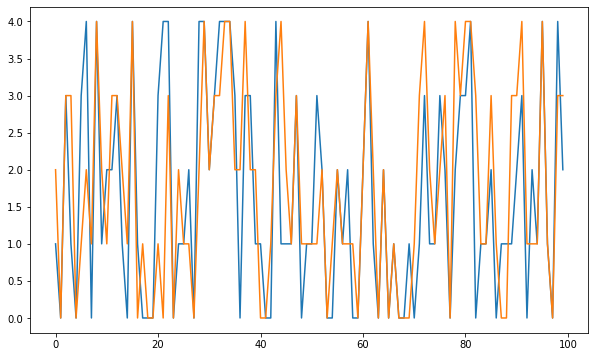

In [279]:
predict_synergy = loaded_model.predict(x_synergy_test[:100])
x = np.arange(100)
predict_synergy_max = np.zeros((100, 1))
y_synergy_test_max = np.zeros((100, 1))
for i in range(100):
    predict_synergy_max[i] = np.argmax(predict_synergy[i])
    y_synergy_test_max[i] = np.argmax(y_synergy_test[i])
plt.figure(figsize = (10, 6))
plt.plot(x, predict_synergy_max[:100])
plt.plot(x, y_synergy_test_max[:100])
plt.show()

4/4 [==============================] - 0s 1ms/step


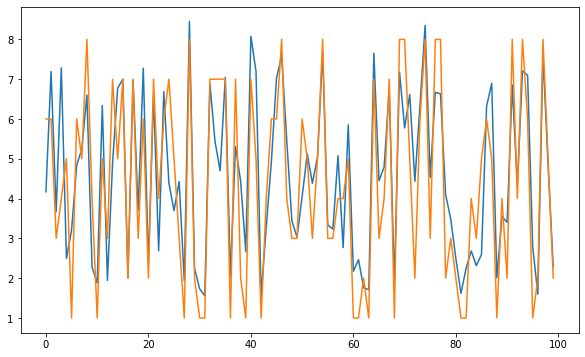

In [280]:
predict_rank = loaded_model_rank.predict(x_rank_test[:100])
x = np.arange(100)
plt.figure(figsize = (10, 6))
plt.plot(x, predict_rank)
plt.plot(x, y_rank_test[:100])
plt.show()

4/4 [==============================] - 0s 1ms/step


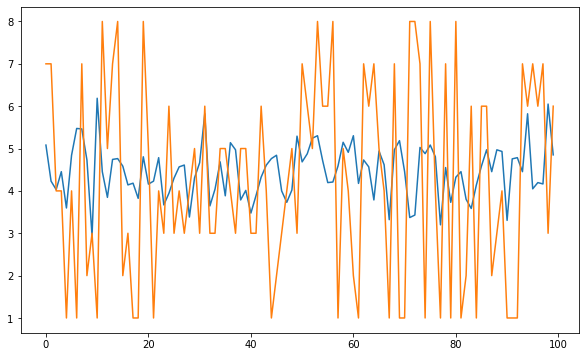

In [336]:
predict_item = loaded_model_item.predict(x_item_test[:100])
x = np.arange(100)
plt.figure(figsize = (10, 6))
plt.plot(x, predict_item)
plt.plot(x, y_item_test[:100])
plt.show()

In [189]:
def suggest(_champ_list, N):
    global word_dic
    champ_list = list(_champ_list)
    all_list = [w for w in word_dic]
    for c in champ_list:
        for i, al in enumerate(all_list):
            if al == c:
                del all_list[i]
    champ_list.pop(N)
    
    suggest_champ_list = []
    while len(all_list) > 0:
        suggest_champ = list(champ_list)
        suggest_champ.append(all_list.pop(0))
        suggest_champ_list.append(suggest_champ)
    
    for i, _ in enumerate(suggest_champ_list):
        trainer = 0
        if "TFT7_Heimerdinger" in suggest_champ_list[i]:
            trainer += 1
        if "TFT7_Tristana" in suggest_champ_list[i]:
            trainer += 1
        if "TFT7_Lulu" in suggest_champ_list[i]:
            trainer += 1
        if trainer >= 2:
            if "TFT7_TrainerDragon" not in suggest_champ_list[i]:
                suggest_champ_list[i].append("TFT7_TrainerDragon")
        else:
            if "TFT7_TrainerDragon" in suggest_champ_list[i]:
                suggest_champ_list[i].pop(suggest_champ_list[i].index("TFT7_TrainerDragon"))
        suggest_champ_list[i] = sorted(suggest_champ_list[i])

    return suggest_champ_list

def suggestion(deck, _model, cutoff):
    global word_dic
    original_predict = loaded_model.predict(deck.reshape(1, 60), verbose = 0)[0]
    champ_list = word_decoder(word_dic, deck)
    suggest_deck_list = []
    for i in range(len(champ_list)):
        suggest_champ_list = suggest(champ_list, i)
        _deck = np.zeros((len(suggest_champ_list), len(deck)))
        for j, s in enumerate(suggest_champ_list):
            _deck[j] = word_encoder(word_dic, s)
        predict = _model.predict(_deck, verbose = 0)
        for j, p in enumerate(predict):
            if p[0] > original_predict[0]:
                suggest_deck_list.append((suggest_champ_list[j], p[0]))
    suggest_deck_list = sorted(suggest_deck_list, key = lambda x:x[1], reverse = True)
    return suggest_deck_list[:cutoff]

def suggestion_N(deck, _model, cutoff, N):
    sg = suggestion(deck, _model, cutoff)
    sg2 = []
    for _ in range(N):
        for s in sg:
            sg2 += suggestion(word_encoder(word_dic, s[0]), _model, cutoff)
        sg2 = sorted(sg2, key = lambda x:x[1], reverse = True)
        sg = sg2
        sg2 = []
    return sg

In [229]:
print(word_decoder(word_dic, x_synergy_test[0]))
predict = loaded_model.predict(x_synergy_test[0].reshape(1, 60))
print(predict)
print(np.argmax(predict))
sg = suggestion_N(x_synergy_test[0], loaded_model, 2, 3)
stars = [2, 2, 2, 2, 2, 2, 2]
sg_star = np.zeros((len(sg), vocab_size_star))
for i, _sg in enumerate(sg):
    __sg = []
    for j, s in enumerate(_sg[0]):
        __sg.append(s + "-" + str(stars[j]))
    sg_star[i] = word_encoder(word_dic_star, __sg)

predict_rank = loaded_model_rank.predict(sg_star)
result_list = []
for i, p in enumerate(predict_rank):
    if (sg[i], p) not in result_list:
        result_list.append((sg[i], p))
result_list = sorted(result_list, key = lambda x:x[1])
for r in result_list:
    print(r[0])
    print(r[1])
    print("")

['TFT7_Nunu', 'TFT7_Gnar', 'TFT7_Yone', 'TFT7_DragonBlue', 'TFT7_Thresh', 'TFT7_Leona', 'TFT7_Twitch']
1/1 [==============================] - 0s 14ms/step
[[0.09410758 0.26837036 0.31551418 0.21383865 0.10816921]]
2
1/1 [==============================] - 0s 13ms/step
(['TFT7_DragonBlue', 'TFT7_Leona', 'TFT7_Nunu', 'TFT7_Ornn', 'TFT7_Sejuani', 'TFT7_Yasuo', 'TFT7_Yone'], 0.8474863)
[2.7103908]

(['TFT7_DragonBlue', 'TFT7_Leona', 'TFT7_Nunu', 'TFT7_Ornn', 'TFT7_Shen', 'TFT7_Yasuo', 'TFT7_Yone'], 0.8783827)
[3.5250235]

(['TFT7_DragonBlue', 'TFT7_Leona', 'TFT7_Nunu', 'TFT7_Olaf', 'TFT7_Ornn', 'TFT7_Shen', 'TFT7_Yone'], 0.8932535)
[4.725932]

(['TFT7_Braum', 'TFT7_DragonBlue', 'TFT7_Leona', 'TFT7_Nunu', 'TFT7_Ornn', 'TFT7_Shen', 'TFT7_Yone'], 0.8663293)
[5.452745]

(['TFT7_Braum', 'TFT7_Leona', 'TFT7_Lillia', 'TFT7_Nunu', 'TFT7_Ornn', 'TFT7_Shen', 'TFT7_Yone'], 0.834956)
[6.957389]



In [358]:
data_I_set = np.unique(data_I, axis = 0, return_counts = True)
np.flip(data_I_set[0], axis = 0)
np.flip(data_I_set[1], axis = 0)

predict_item = model_item.predict(data_I_set[0])
result_set = {}
for i, d in enumerate(data_I_set[0]):
    champ_item = word_decoder(word_dic_item, d)
    for j, c in enumerate(champ_item):
        if c in list(word_dic.keys()):
            champ = champ_item.pop(j)
    if champ not in list(result_set.keys()):
        result_set[champ] = []
    result_set[champ].append([champ_item, predict_item[i][0], data_I_set[1][i]])

for r in result_set:    
    result_set[r] = sorted(result_set[r], key = lambda x:x[1])

1447/1447 [==============================] - 1s 802us/step


In [379]:
# 아이템 이름
# 태불망 => RedBuff
# 정손 => UnstableConcoction
# 밤끝 => GuardianAngel
for r in result_set['TFT7_AoShin']:
    if r[2] > 50:
        print(r[0], r[1], r[2])

['TFT_Item_SpearOfShojin', 'TFT_Item_ArchangelsStaff', 'TFT_Item_HextechGunblade'] 3.1992512 214
['TFT_Item_SpearOfShojin', 'TFT_Item_ArchangelsStaff', 'TFT_Item_JeweledGauntlet'] 3.2646341 82
['TFT_Item_SpearOfShojin', 'TFT_Item_HextechGunblade', 'TFT7_Item_MageEmblemItem'] 3.3377137 89
['TFT_Item_SpearOfShojin', 'TFT_Item_InfinityEdge', 'TFT_Item_JeweledGauntlet'] 3.3687413 62
['TFT_Item_SpearOfShojin', 'TFT_Item_ArchangelsStaff', 'TFT7_Item_MageEmblemItem'] 3.3977215 118
['noItems'] 5.1771574 66


In [371]:
print(word_dic_item)

{'noItems': 1, 'TFT_Item_GuinsoosRageblade': 2, 'TFT_Item_RedBuff': 3, 'TFT_Item_Bloodthirster': 4, 'TFT_Item_GargoyleStoneplate': 5, 'TFT_Item_WarmogsArmor': 6, 'TFT_Item_SpearOfShojin': 7, 'TFT_Item_TitansResolve': 8, 'TFT7_Lulu': 9, 'TFT_Item_ArchangelsStaff': 10, 'TFT7_Sylas': 11, 'TFT_Item_InfinityEdge': 12, 'TFT_Item_Quicksilver': 13, 'TFT7_Ornn': 14, 'TFT7_Bard': 15, 'TFT_Item_UnstableConcoction': 16, 'TFT_Item_BrambleVest': 17, 'TFT7_Yasuo': 18, 'TFT_Item_Redemption': 19, 'TFT7_TrainerDragon': 20, 'TFT7_Item_TrainerSnax': 21, 'TFT_Item_DragonsClaw': 22, 'TFT_Item_JeweledGauntlet': 23, 'TFT7_Nami': 24, 'TFT_Item_HextechGunblade': 25, 'TFT_Item_IonicSpark': 26, 'TFT7_Hecarim': 27, 'TFT_Item_StatikkShiv': 28, 'TFT_Item_FrozenHeart': 29, 'TFT7_Shen': 30, 'TFT_Item_ZekesHerald': 31, 'TFT7_Zoe': 32, 'TFT7_Neeko': 33, 'TFT7_Illaoi': 34, 'TFT7_Heimerdinger': 35, 'TFT_Item_Morellonomicon': 36, 'TFT7_Swain': 37, 'TFT7_Sona': 38, 'TFT7_Tristana': 39, 'TFT_Item_SeraphsEmbrace': 40, 'TFT_It